## Ayush Kumar

## Twitter Sentiment analysis

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
import re, nltk
import string
import xgboost as xgb
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, precision_recall_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Ayush\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Ayush\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Reading data

In [2]:
df =pd.read_csv('Tweets.csv')
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [3]:
df['airline_sentiment'].unique()

array(['neutral', 'positive', 'negative'], dtype=object)

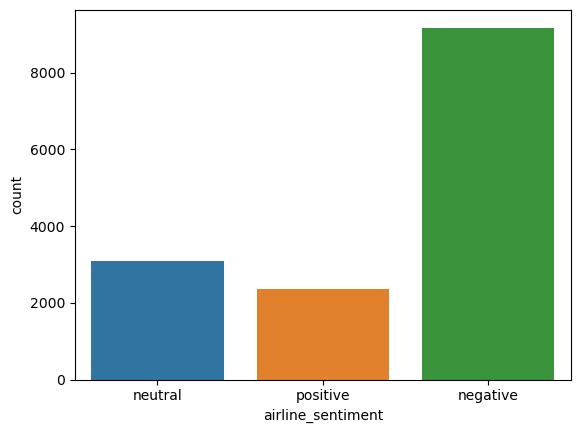

In [4]:
ax = sns.countplot(x="airline_sentiment", data=df)

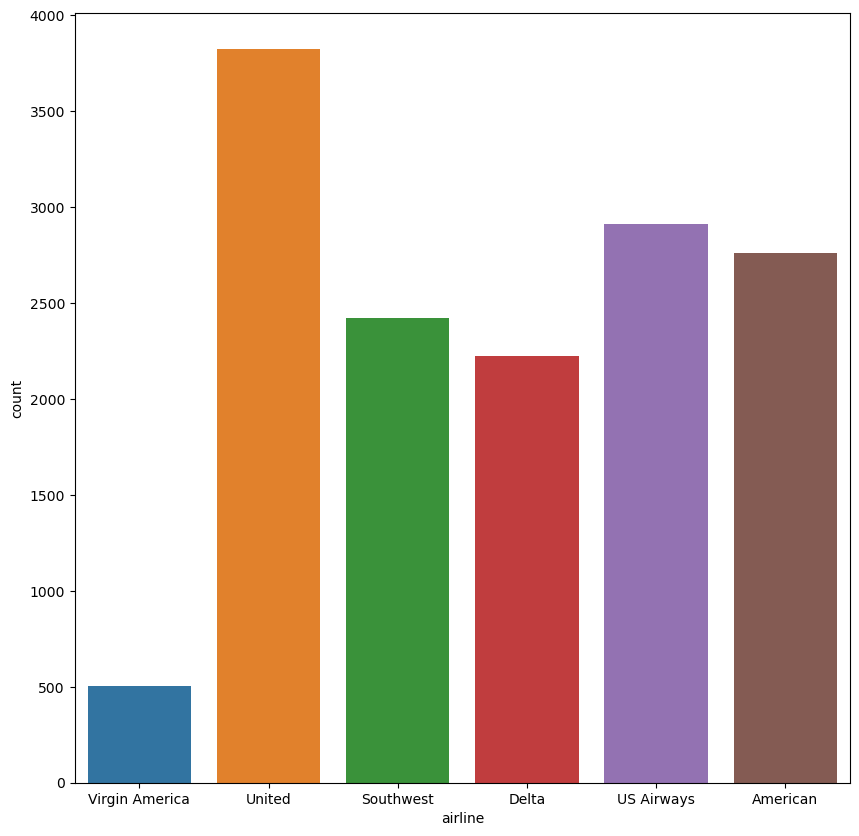

In [5]:
plt.figure(figsize=(10,10))
ax = sns.countplot(x="airline", data=df)

## Data processing

<AxesSubplot:>

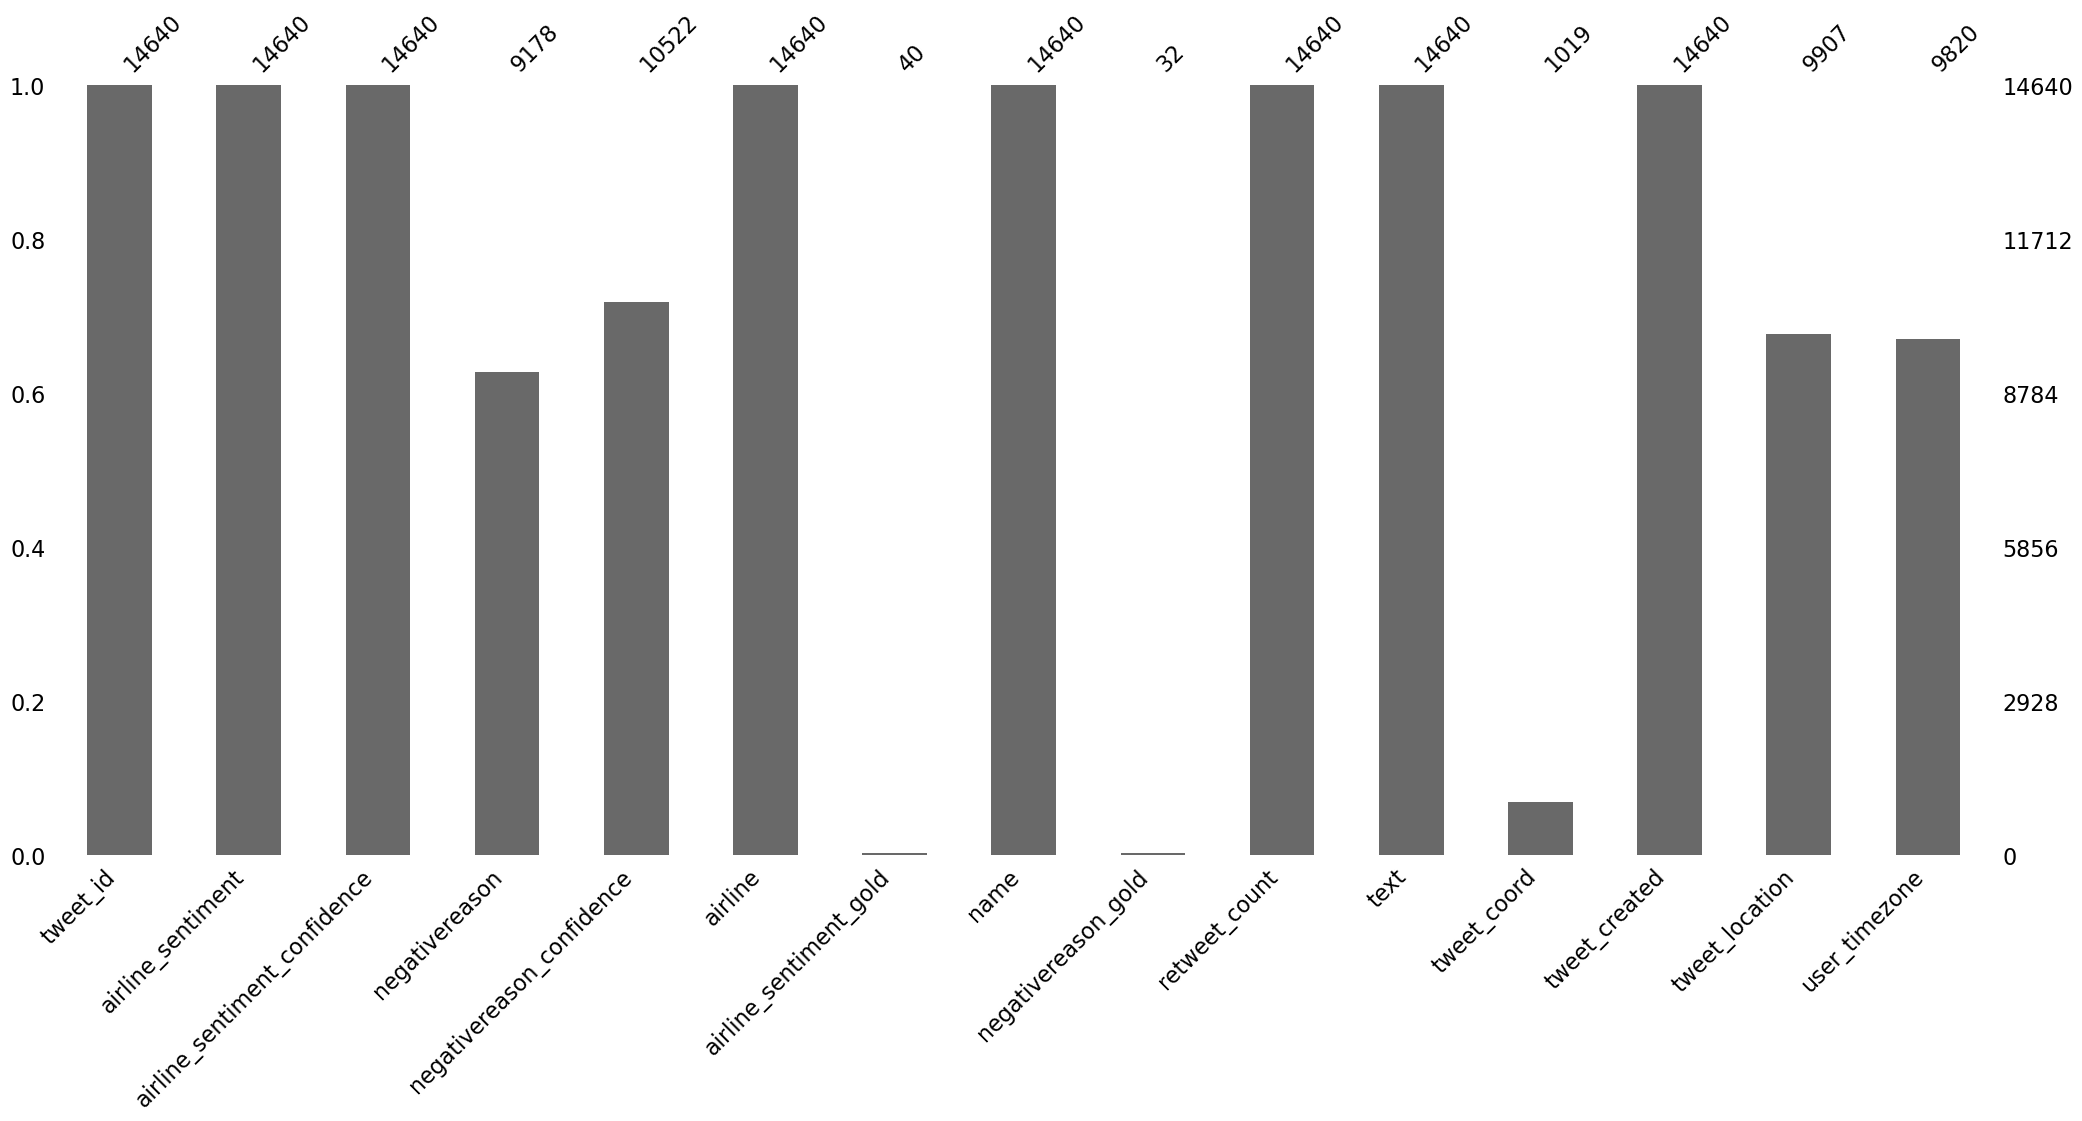

In [6]:
import missingno as msno
msno.bar(df)

In [7]:
df = df.drop(['airline_sentiment_gold','negativereason_gold','tweet_coord'], axis=1)

In [8]:
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,name,retweet_count,text,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,cairdin,0,@VirginAmerica What @dhepburn said.,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,jnardino,0,@VirginAmerica plus you've added commercials t...,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,yvonnalynn,0,@VirginAmerica I didn't today... Must mean I n...,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,jnardino,0,@VirginAmerica it's really aggressive to blast...,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,jnardino,0,@VirginAmerica and it's a really big bad thing...,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [9]:
def clean_the_tweet(text):
  tokens= nltk.word_tokenize(re.sub("[^a-zA-Z]", " ",text))
  tokens = [token.lower() for token in tokens]
  return ' '.join(tokens[2:])

                 

def text_process(msg):
  nopunc =[char for char in msg if char not in string.punctuation]
  nopunc=''.join(nopunc)
  return ' '.join([word for word in nopunc.split() if word.lower() not in stopwords.words('english')])



In [10]:
df = df[df['airline_sentiment']!='neutral']
df['cleaned_tweet'] = df['text'].apply(clean_the_tweet)

df.head()


,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,name,retweet_count,text,tweet_created,tweet_location,user_timezone,cleaned_tweet
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,jnardino,0,@VirginAmerica plus you've added commercials t...,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada),you ve added commercials to the experience tacky
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,jnardino,0,@VirginAmerica it's really aggressive to blast...,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada),s really aggressive to blast obnoxious enterta...
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,jnardino,0,@VirginAmerica and it's a really big bad thing...,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada),it s a really big bad thing about it
5,570300767074181121,negative,1.0000,Can't Tell,0.6842,Virgin America,jnardino,0,@VirginAmerica seriously would pay $30 a fligh...,2015-02-24 11:14:33 -0800,NaN,Pacific Time (US & Canada),would pay a flight for seats that didn t have ...
6,570300616901320704,positive,0.6745,NaN,0.0000,Virgin America,cjmcginnis,0,"@VirginAmerica yes, nearly every time I fly VX...",2015-02-24 11:13:57 -0800,San Francisco CA,Pacific Time (US & Canada),nearly every time i fly vx this ear worm won t...


In [11]:
df['airline_sentiment'] = df['airline_sentiment'].apply(lambda x: 1 if x =='positive' else 0)
df['airline_sentiment'].head()

1    1
3    0
4    0
5    0
6    1
Name: airline_sentiment, dtype: int64

In [12]:
df['cleaned_tweet'] = df['cleaned_tweet'].apply(text_process)
df.reset_index(drop=True, inplace = True)
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,name,retweet_count,text,tweet_created,tweet_location,user_timezone,cleaned_tweet
0,570301130888122368,1,0.3486,NaN,0.0000,Virgin America,jnardino,0,@VirginAmerica plus you've added commercials t...,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada),added commercials experience tacky
1,570301031407624196,0,1.0000,Bad Flight,0.7033,Virgin America,jnardino,0,@VirginAmerica it's really aggressive to blast...,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada),really aggressive blast obnoxious entertainmen...
2,570300817074462722,0,1.0000,Can't Tell,1.0000,Virgin America,jnardino,0,@VirginAmerica and it's a really big bad thing...,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada),really big bad thing
3,570300767074181121,0,1.0000,Can't Tell,0.6842,Virgin America,jnardino,0,@VirginAmerica seriously would pay $30 a fligh...,2015-02-24 11:14:33 -0800,NaN,Pacific Time (US & Canada),would pay flight seats playing really bad thin...
4,570300616901320704,1,0.6745,NaN,0.0000,Virgin America,cjmcginnis,0,"@VirginAmerica yes, nearly every time I fly VX...",2015-02-24 11:13:57 -0800,San Francisco CA,Pacific Time (US & Canada),nearly every time fly vx ear worm go away


## Data transformation

In [13]:

vectorizer = TfidfVectorizer(use_idf=True, lowercase=True)
X_tf_idf= vectorizer.fit_transform(df.cleaned_tweet)


## Splitting Data

In [14]:
x_train, x_test, y_train, y_test = train_test_split(X_tf_idf, df['airline_sentiment'], random_state=42)


## Decision Tree using Sklearn

In [15]:


# Define decision tree classifier model
model = DecisionTreeClassifier()

# Train the model on the training data
model.fit(x_train, y_train)

# Predict on the test data
y_pred = model.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
conf = confusion_matrix(y_test, y_pred)

# Print the results
print("Accuracy: {:.2f}%".format(accuracy * 100.0))
print("F1 score: {:.2f}%".format(f1 * 100.0))
print("Precision: {:.2f}%".format(precision * 100.0))
print("Recall: {:.2f}%".format(recall * 100.0))
print("Confusion matrix: \n", conf)



Accuracy: 83.19%
F1 score: 58.79%
Precision: 56.35%
Recall: 61.46%
Confusion matrix: 
 [[2055  268]
 [ 217  346]]


## Random Forest using Sklearn

In [17]:


# Define the random forest model
model = RandomForestClassifier()

# Train the model on the training data
model.fit(x_train, y_train)

# Predict on the test data
y_pred = model.predict(x_test)

# Calculate accuracy, F1 score, precision, recall, and confusion matrix
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
conf = confusion_matrix(y_test, y_pred)

# Print the results
print("Accuracy: {:.2f}%".format(accuracy * 100.0))
print("F1 score: {:.2f}%".format(f1 * 100.0))
print("Precision: {:.2f}%".format(precision * 100.0))
print("Recall: {:.2f}%".format(recall * 100.0))
print("Confusion matrix: \n", conf)



Accuracy: 88.15%
F1 score: 64.89%
Precision: 76.89%
Recall: 56.13%
Confusion matrix: 
 [[2228   95]
 [ 247  316]]


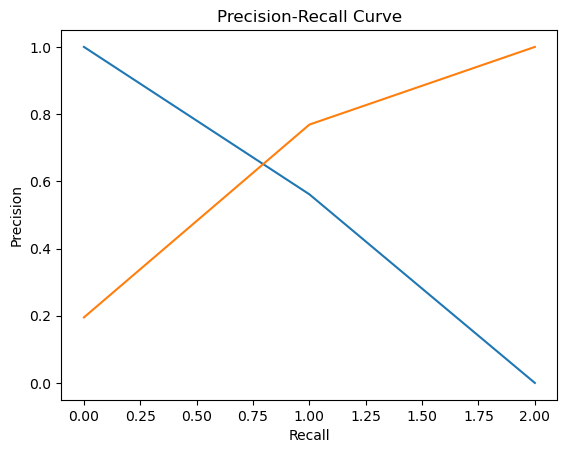

In [18]:

# Calculate precision and recall
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)

# Plot the precision-recall curve
plt.plot(recall)
plt.plot(precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

## Randomforest using xgboost

In [19]:


# Define random forest classifier model with XGBoost
model = xgb.XGBClassifier()

import xgboost as xgb

# create xgboost object
params = {
  'colsample_bynode': 0.8,
  'learning_rate': 1,
  'max_depth': 5,
  'num_parallel_tree': 100,
  'objective': 'binary:logistic',
  'subsample': 0.8,
  'tree_method': 'gpu_hist'
}
xgb_model = xgb.XGBClassifier(**params)



In [20]:
# train the model using the training sets
xgb_model.fit(x_train, y_train)
y_pred = xgb_model.predict(x_test)

In [21]:
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
conf = confusion_matrix(y_test, y_pred)

# Print the results
print("Accuracy: {:.2f}%".format(accuracy * 100.0))
print("F1 score: {:.2f}%".format(f1 * 100.0))
print("Precision: {:.2f}%".format(precision * 100.0))
print("Recall: {:.2f}%".format(recall * 100.0))
print("Confusion matrix: \n", conf)


Accuracy: 84.86%
F1 score: 45.98%
Precision: 75.61%
Recall: 33.04%
Confusion matrix: 
 [[2263   60]
 [ 377  186]]


## Decision Tree using XGBoost

In [22]:


# Define the parameters for the decision tree
params = {
    'max_depth': 5,
    'min_child_weight': 1,
    'gamma': 0,
    
}
# Create the XGBoost decision tree model with the defined parameters
model = xgb.XGBClassifier(**params)

# Train the model on the training data
model.fit(x_train, y_train)


# Predict on the test data
y_pred = model.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
conf = confusion_matrix(y_test, y_pred)

# Print the results
print("Accuracy: {:.2f}%".format(accuracy * 100.0))
print("F1 score: {:.2f}%".format(f1 * 100.0))
print("Precision: {:.2f}%".format(precision * 100.0))
print("Recall: {:.2f}%".format(recall * 100.0))
print("Confusion matrix: \n", conf)


Accuracy: 86.76%
F1 score: 55.58%
Precision: 80.47%
Recall: 42.45%
Confusion matrix: 
 [[2265   58]
 [ 324  239]]
